# Figure 7 Flood risk of motorways and trunk roads in the European main road network

In [1]:
import sys
sys.path.append("..") #import folder which is one level higher

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os as os
import postproc_functions as post
import pandas as pd
from tqdm import tqdm
from collections import OrderedDict

from utils_functions import load_config

### Load NUTS-shapefiles to be used as background layers

In [2]:
# Load the background NUTS-division shapefiles as background maps.
NUTS3 = gpd.read_file(os.path.join(load_config()['paths']['input_data'],load_config()['filenames']['NUTS3-shape']))
ori = NUTS3.copy()

NUTS0 = post.NUTS_0_list(EU28=True,EFTA=True,CAND=True) #draw the list of NUTS-0 regions
NUTS0 = [e for e in NUTS0 if e not in ['IS','MT','CY','TR']] #drop Iceland, Malta and Cyprus, Turkey for now
NUTS3_lst = []
for N0 in NUTS0:
    NUTS3_lst.extend(post.NUTS_up(N0,True)) #find all the correspondign NUTS-3 regions
regions = [e for e in NUTS3_lst if e not in post.NUTS_3_remote(Overseas=True,Creta=True,Spain=True)] #remove all the NUTS-3 regions we don't want to plot

NUTS3 = NUTS3[NUTS3['NUTS_ID'].isin(regions)]
NUTS3.head()

LEVL_CODE NUTS_ID CNTR_CODE                    NUTS_NAME    FID  \
0          3   HR043        HR  Krapinsko-zagorska županija  HR043   
1          3   AT314        AT              Steyr-Kirchdorf  AT314   
2          3   AT315        AT                 Traunviertel  AT315   
3          3   DE600        DE                      Hamburg  DE600   
4          3   DE711        DE  Darmstadt, Kreisfreie Stadt  DE711   

                                            geometry  
0  POLYGON ((4804562.000 2571297.000, 4803972.000...  
1  POLYGON ((4654777.000 2787028.000, 4653848.000...  
2  POLYGON ((4600507.000 2785382.000, 4600808.000...  
3  MULTIPOLYGON (((4317388.000 3393935.000, 43177...  
4  POLYGON ((4229546.000 2983212.000, 4230168.000...

In [3]:
background = gpd.read_file(os.path.join(load_config()['paths']['input_data'],load_config()['filenames']['NUTS0-shape'])) #country map (NUTS-0)

### Set the domain of the plot in EPSG:3035 coordinates

In [4]:
#Get x- and y-axis from the chosen domain

#Define x and y-axis for further use in the script
#x_axis = ax_base.get_xlim()
#y_axis = ax_base.get_ylim()

#... or set them manually:

x_axis = (2500000, 5900000)
y_axis = (1500000, 5400000)
print(x_axis,y_axis)

(2500000, 5900000) (1500000, 5400000)


### Load the not-yet-disrupted motorway network of Europe

In [5]:
# Load backgroundmap containing the (not-yet-disrupted) motorway network of Europe
background_maps = r"D:/Europe_trade_disruptions/EuropeFloodResults/Model08_VMs/main/total_network"

#LOAD AND FILTER THE BACKGROUND MAP DATA
df_mw = pd.DataFrame()
df_tr = pd.DataFrame()
exceptions_bg = OrderedDict()
for region in tqdm(regions):
    try:
        df = pd.read_pickle(os.path.join(background_maps,"{}.pkl".format(region)))
        df_mw = df_mw.append(df.loc[df['road_type']=='motorway'])
        df_tr = df_tr.append(df.loc[df['road_type']=='trunk']) 
        #results = results.append(pd.read_pickle(os.path.join(background_maps,"{}.pkl".format(region))))
    except Exception as e:
        exceptions_bg[region] = str(e)
print(exceptions_bg)

100%|██████████████████████████████████████████████████████████████████████████████| 1417/1417 [05:32<00:00,  4.26it/s]

OrderedDict()


### Load the model results

In [6]:
# Load folder containing all model results
result_path = os.path.join(load_config()['paths']['postproc_output'],'baseline')

#LOAD THE FLOOD DATA
flood_mw = pd.DataFrame()
flood_tr = pd.DataFrame()
exceptions_flood = OrderedDict()
for region in tqdm(regions):
    try:
        df = pd.read_pickle(os.path.join(result_path,"{}_EAD_segment_litmix.pkl".format(region)))
        flood_mw = flood_mw.append(df.loc[df['road_type']=='motorway'])
        flood_tr = flood_tr.append(df.loc[df['road_type']=='trunk'])
    except Exception as e:
        exceptions_flood[region] = str(e)

#print(exceptions_flood)

100%|██████████████████████████████████████████████████████████████████████████████| 1417/1417 [03:27<00:00,  6.84it/s]


In [7]:
#set the projections of the source data to be able to convert it to another projection when plotting
CRS84 = {'init':'epsg:4326'}
CRSEU = {'init':'epsg:3035'}
df_mw.crs = CRS84
df_tr.crs = CRS84
flood_mw.crs = CRS84
flood_tr.crs = CRS84

C:\Users\Ginkel\AppData\Local\Continuum\anaconda3\envs\Leerdam37\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


# Choose colour scheme

In [8]:
scheme_name = "colour_scheme_dark_2"

#Region colours
background_color = "#706F6F" 
nodata = "grey" #regions with no data

#Line colours
country_borders = '#404040' #lines indicating the borders of countries 25% grey
NUTS_3_lines = "grey" #border of NUTS-regions
road_noflood = '#CCC155' #Roads that are not inundated
colors = ['#69CBF5','#FF3BFF']
colorgrading = mpl.colors.LinearSegmentedColormap.from_list(name='blauw',colors=colors,N=4) #colormap used for coloring the inundated roads

#Line thickness
l_mw_no = 2 #motorway not flooded
l_tr_no = 1 #trunk not flooded
l_mw_fl = 3 #motorway flooded
l_tr_fl = 2 #trunk flooded

In [11]:
#OSM COLOUR SCHEME - default theme

#scheme_name = "colour_scheme_OSM"

#Region colours
#background_color = "#F1F2DC" #OSM background color
#nodata = "#b5b4b0" #regions with no data

#Line colours
#country_borders = "#b5b4b0" #lines indicating the borders of countries
#NUTS_3_lines = "white" #border of NUTS-regions
#road_noflood = '#E892A2' #Roads that are not inundated
#colorgrading = mpl.colors.LinearSegmentedColormap.from_list(name='blauw',colors=['#58AACC','#58AACC','#58AACC','#58AACC','#58AACC'],N=20) #colormap used for coloring the inundated roads
#colorgrading = mpl.colors.LinearSegmentedColormap.from_list(name='blauw',colors=['#58AACC','#E34094'],N=4) #colormap used for coloring the inundated roads
#colorgrading = mpl.colors.LinearSegmentedColormap.from_list(name='blauw',colors=['#58AACC','#b4dc3c','#EB741A'],N=3) #colormap used for coloring the inundated roads
#colorgrading = mpl.colors.LinearSegmentedColormap.from_list(name='blauw',colors=['#b4dc3c','#58AACC'],N=10) #colormap used for coloring the inundated roads

#Line thickness
#l_mw_no = 2 #motorway not flooded
#l_tr_no = 1 #trunk not flooded
#l_mw_fl = 3 #motorway flooded
#l_tr_fl = 2 #trunk flooded

C:\Users\Ginkel\AppData\Local\Continuum\anaconda3\envs\Leerdam37\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\Users\Ginkel\AppData\Local\Continuum\anaconda3\envs\Leerdam37\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\Users\Ginkel\AppData\Local\Continuum\anaconda3\envs\Leerdam37\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\Users\Ginkel\AppData\Local\Continuum\anaconda3\envs\Leerdam37\lib\site-packages\geopandas\plotting.py:529: UserWarning: The GeoDataFrame you are attempting to plot is empty. N

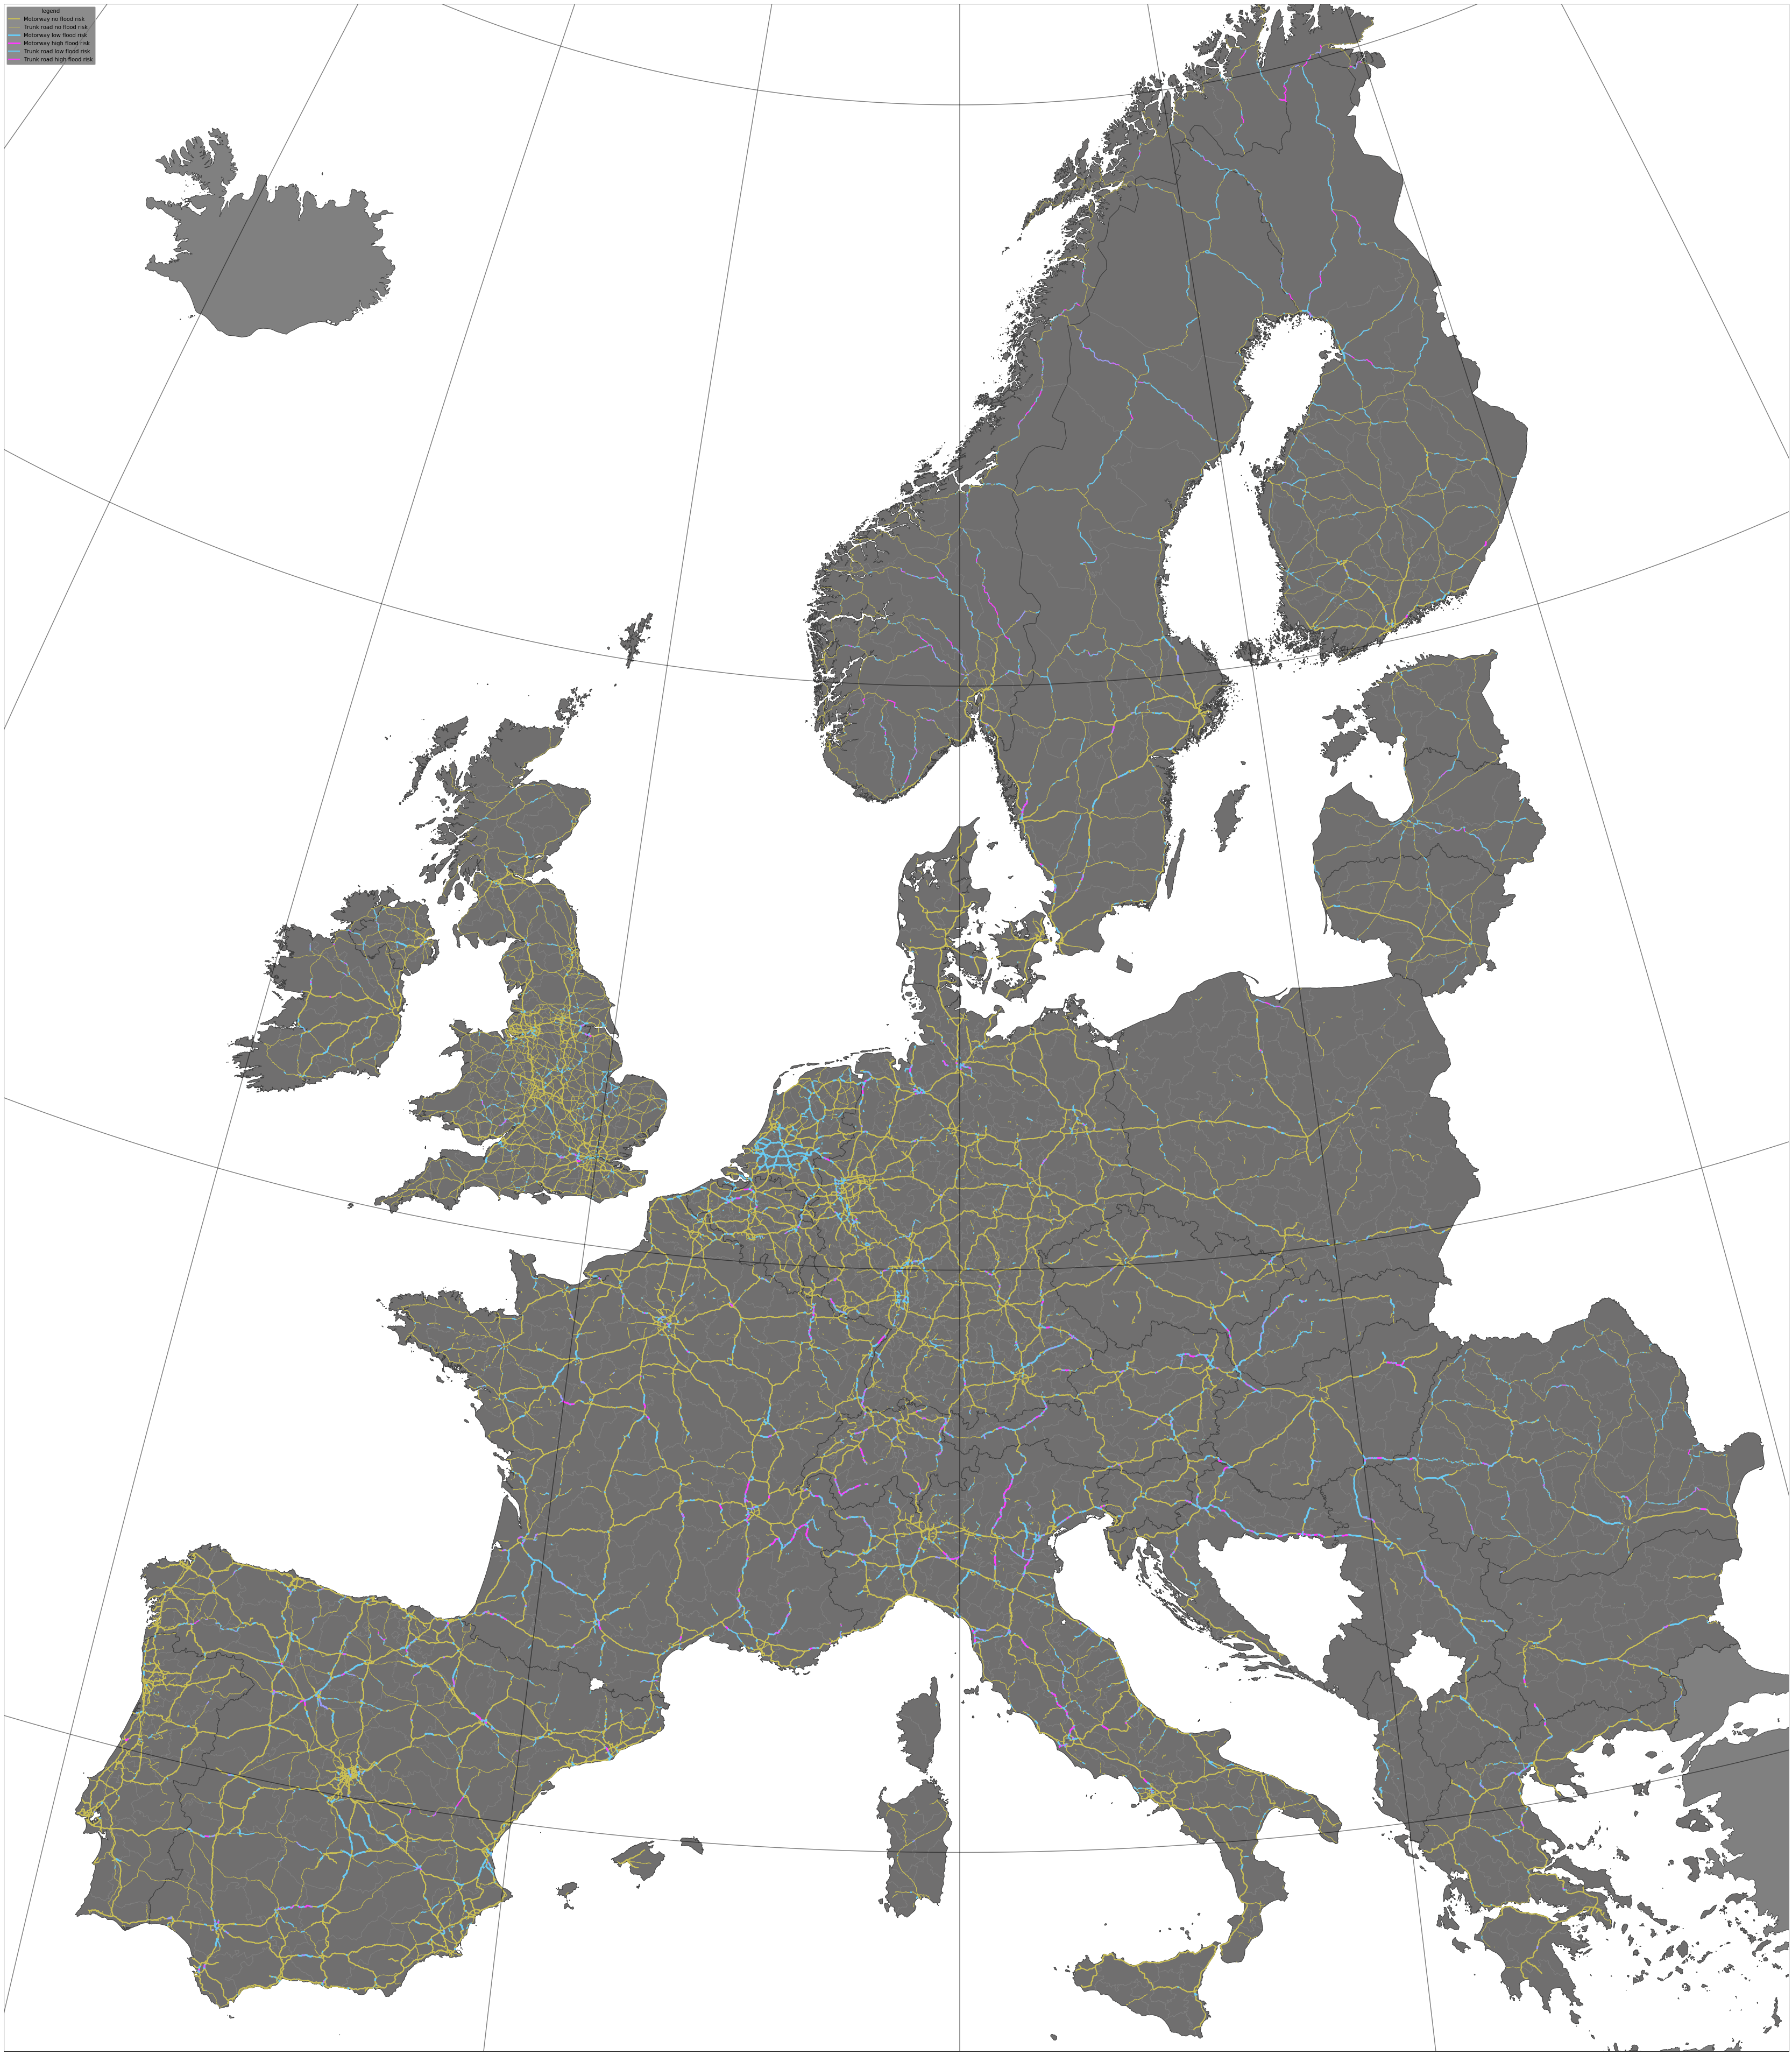

In [24]:
### MAKE THE PLOT
### FILTER AND PLOT ALL BACKGROUND DATA ###

fig, ax = plt.subplots(1, 1, figsize=(70,70))
#Background (country) map - used for areas without data
background.to_crs(CRSEU).plot(color=nodata,ax=ax) #Print the face color

#Background (NUTS-3) map
NUTS3.to_crs(CRSEU).plot(ax=ax, color=background_color, edgecolor=NUTS_3_lines) #lichtgrijs = #DFDFDF
#N0.loc[N0['FID']==super_region].to_crs({'init':'epsg:4326'}).plot(ax=ax, color='#DFDFDF')

# Plot the regions for which no background map data is available
no_background = ori[ori['NUTS_ID'].isin(list(exceptions_bg.keys()))]
no_background.to_crs(CRSEU).plot(ax=ax, color='grey')

# Plot the regions for which no background flood data is available
#no_flood = ori[ori['NUTS_ID'].isin(list(exceptions_flood.keys()))]
#no_flood.to_crs(CRSEU).plot(ax=ax, color='#DFDFDF')

#plot the country contour lines
background.to_crs(CRSEU).plot(facecolor='none',ax=ax,edgecolor=country_borders)

#Plot the background road map
df_tr.to_crs(CRSEU).plot(color=road_noflood, linewidth=l_tr_no,ax=ax)
df_mw.to_crs(CRSEU).plot(color=road_noflood, linewidth=l_mw_no,ax=ax)

ax.set_xlim(x_axis)
ax.set_ylim(y_axis)

#### PLOT FLOOD DATA ###
flood_tr.to_crs(CRSEU).plot(column='EAD_highflow',ax=ax, cmap=colorgrading, linewidth=l_tr_fl, legend=False, vmin=0, vmax=30000) 
flood_mw.to_crs(CRSEU).plot(column='EAD_highflow',ax=ax, cmap=colorgrading, linewidth=l_mw_fl, legend=False, vmin=0, vmax=30000) 

ax.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,labelbottom=False,labelleft=False)

#### #add gridlines

#New feature (14/4/2020): plot the gridlines of WGS84
#Ps, Ms = post.create_gridlines([20,25,30,35,40,45,50,55,60,65,70,75,80,85],
#                      [-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85],
#                      point_spacing = 10000)
Ps, Ms = post.create_gridlines([20,30,40,50,60,70,80],
                      [-30,-20,-10,0,10,20,30,40,50,60,70,80],
                      point_spacing = 10000)
Ps = Ps.to_crs("EPSG:3035")
Ms = Ms.to_crs("EPSG:3035")
lijndikte = 1.5
alfa = 0.5
Ps.plot(ax=ax,color='black',linewidth=lijndikte,alpha=alfa)
Ms.plot(ax=ax,color='black',linewidth=lijndikte,alpha=alfa)


### PREPARE LEGEND AND OTHER METADATA ###
legend_entries = []
legend_entries.append(plt.Line2D([0], [0], color=road_noflood, lw=l_mw_no, label='Motorway no flood risk'))
legend_entries.append(plt.Line2D([0], [0], color=road_noflood, lw=l_tr_no, label='Trunk road no flood risk'))
legend_entries.append(plt.Line2D([0], [0], color=colors[0], lw=l_mw_fl, label='Motorway low flood risk'))
legend_entries.append(plt.Line2D([0], [0], color=colors[1], lw=l_mw_fl, label='Motorway high flood risk'))
legend_entries.append(plt.Line2D([0], [0], color=colors[0], lw=l_tr_fl, label='Trunk road low flood risk'))
legend_entries.append(plt.Line2D([0], [0], color=colors[1], lw=l_tr_fl, label='Trunk road high flood risk'))

ax.legend(handles=legend_entries,loc='upper left',facecolor=background_color,title='legend')

In [23]:
#fig.savefig("Paper_fig9_backgroundmap_{}_gridlines_fat.png".format(scheme_name), dpi=250, bbox_inches="tight")

# Save the results as a shapefile

In [17]:
flood_tr.head()

infra_type                                           geometry  \
osm_id                                                                    
218323021      trunk  LINESTRING (19.63367 41.07333, 19.62831 41.076...   
229282370      trunk  LINESTRING (19.63701 41.07226, 19.63806 41.070...   
234350419      trunk  LINESTRING (19.64549 41.06363, 19.64492 41.065...   
240359305      trunk  LINESTRING (19.63362 41.07326, 19.63473 41.072...   
290372980      trunk  LINESTRING (19.63711 41.07255, 19.63696 41.072...   

           lanes  bridge  lit    length road_type  length_rp10  val_rp10  \
osm_id                                                                     
218323021    2.0     NaN  NaN  9.543838     trunk     0.192580        60   
229282370    2.0     NaN  NaN  1.209308     trunk     0.661992        96   
234350419    2.0     NaN  NaN  1.205781     trunk     0.734459       103   
240359305    1.0     NaN  NaN  0.234271     trunk     0.028645        10   
290372980    1.0     NaN  NaN  0.123059     trunk     0.065309        50   

           length_rp20  ...  Jongman_FP      EAD_C1      EAD_C2     EAD_C3  \
osm_id                  ...                                                  
218323021     0.192580  ...        50.0   22.181498   44.362996   3.137678   
229282370     0.667180  ...        50.0  113.638951  220.989813  17.930861   
234350419     0.750860  ...        50.0  131.374981  253.738052  20.793483   
240359305     0.028645  ...        50.0    0.780599    1.561199   0.156629   
290372980     0.065309  ...        50.0    5.008315   10.015356   0.734757   

               EAD_C4  EAD_C5  EAD_C6      EAD_HZ  EAD_lowflow EAD_highflow  
osm_id                                                                       
218323021   30.025693     0.0     0.0   54.444569     3.137678    30.025693  
229282370  166.326217     0.0     0.0  268.047341    17.930861   166.326217  
234350419  194.622622     0.0     0.0  294.981199    20.793483   194.622622  
240359305    1.171536     0.0     0.0    2.428390     0.156629     1.171536  
290372980    6.844569     0.0     0.0   10.099401     0.734757     6.844569  

[5 rows x 75 columns]

In [25]:
flood_tr['EAD_avg'] = (flood_tr['EAD_lowflow'] + flood_tr['EAD_highflow']) / 2
flood_mw['EAD_avg'] = (flood_mw['EAD_lowflow'] + flood_mw['EAD_highflow']) / 2

In [35]:
#df_tr.to_file("shapefile/trunk_roads.shp")

In [36]:
#df_mw.to_file("shapefile/motorways.shp")

In [26]:
#remove 'rp' chars from column name, to make create unique names with < 10 chars
flood_tr_exp = flood_tr.copy()
flood_tr_exp.columns = [c.replace("rp","") for c in list(flood_tr.columns)]
flood_tr_exp.to_file("shapefile/flooded_trunk_roads.shp")

In [27]:
flood_mw_exp = flood_tr.copy()
flood_mw_exp.columns = [c.replace("rp","") for c in list(flood_mw.columns)]
flood_mw_exp.to_file("shapefile/flooded_motorways.shp")

In [35]:
flood_mw.to_file("shapefile/mw_package.gpkg", layer='motorways', driver="GPKG")

In [48]:
flood_tr[flood_tr['NUTS-0'] == 'NO']

infra_type                                           geometry  \
osm_id                                                                    
2512955        trunk  LINESTRING (7.82831 58.59815, 7.82860 58.59877...   
4040236        trunk  LINESTRING (7.52502 59.09698, 7.52290 59.09711...   
4040237        trunk  LINESTRING (7.51286 59.11979, 7.51299 59.12070...   
4040238        trunk  LINESTRING (7.53122 59.13538, 7.53296 59.13552...   
4040244        trunk  LINESTRING (7.41031 59.46243, 7.41032 59.46212...   
...              ...                                                ...   
623057586      trunk    LINESTRING (9.84498 63.29670, 9.84635 63.29655)   
623057587      trunk    LINESTRING (9.84631 63.29672, 9.84498 63.29670)   
623057588      trunk    LINESTRING (9.84676 63.29655, 9.84820 63.29657)   
630716070      trunk  LINESTRING (10.27597 63.24388, 10.27611 63.24281)   
630716071      trunk  LINESTRING (10.27623 63.24282, 10.27605 63.24418)   

           lanes  bridge  lit    length road_type  length_rp10  val_rp10  \
osm_id                                                                     
2512955      2.0     NaN  NaN  0.348014     trunk     0.181819       193   
4040236      2.0     NaN  NaN  0.430241     trunk     0.429793         0   
4040237      2.0     NaN  NaN  1.321967     trunk     0.005774        10   
4040238      2.0     NaN  NaN  1.303139     trunk     0.389505       268   
4040244      2.0     NaN  NaN  1.631671     trunk     0.136581        32   
...          ...     ...  ...       ...       ...          ...       ...   
623057586    2.0     NaN  NaN  0.070820     trunk     0.070771        41   
623057587    2.0     NaN  NaN  0.066756     trunk     0.066404        41   
623057588    2.0     NaN  NaN  0.072692     trunk     0.072355        37   
630716070    2.0     NaN  NaN  0.119395     trunk     0.119395         0   
630716071    1.0     NaN  NaN  0.151666     trunk     0.151665         0   

           length_rp20  ...       EAD_C1       EAD_C2       EAD_C3  \
osm_id                  ...                                          
2512955       0.181819  ...   716.801498   832.554307   187.445693   
4040236       0.092710  ...   887.208989  1099.104120   268.485393   
4040237       0.005774  ...     2.215730     4.431461     0.407491   
4040238       0.614540  ...  5662.107865  6233.180524  1137.280899   
4040244       0.136581  ...    52.617228   105.234457    10.518352   
...                ...  ...          ...          ...          ...   
623057586     0.070771  ...    44.085393    88.170787     6.672659   
623057587     0.066404  ...    41.360300    82.746067     6.239700   
623057588     0.072355  ...    41.283895    82.567790     6.443446   
630716070     0.119395  ...    38.889888    77.754307     6.774532   
630716071     0.151665  ...    29.161049    58.322097     5.068165   

                EAD_C4  EAD_C5  EAD_C6       EAD_HZ  EAD_lowflow  \
osm_id                                                             
2512955    1585.036704     0.0     0.0   732.260674   187.445693   
4040236    2208.675655     0.0     0.0   962.161798   268.485393   
4040237       3.234457     0.0     0.0     7.767790     0.407491   
4040238    9945.165543     0.0     0.0  4568.606742  1137.280899   
4040244      78.925843     0.0     0.0   210.468914    10.518352   
...                ...     ...     ...          ...          ...   
623057586    60.741573     0.0     0.0   119.445693     6.672659   
623057587    56.997753     0.0     0.0   112.085393     6.239700   
623057588    57.354307     0.0     0.0   116.949813     6.443446   
630716070    55.800749     0.0     0.0   128.868914     6.774532   
630716071    41.844195     0.0     0.0    75.182022     5.068165   

           EAD_highflow      EAD_avg  
osm_id                                
2512955     1585.036704   886.241199  
4040236     2208.675655  1238.580524  
4040237        3.234457     1.820974  
4040238     9945.165543  5541.223221  
4040244       7

In [42]:
flood_mw[flood_mw['NUTS-0'] == 'NO'].to_file("shapefile/flooded_motorways_NO.shp")

In [50]:
df = flood_tr
road_name = 'trunk'
exceptions = {}
for country in flood_mw['NUTS-0'].unique():
    try:
        selection = df[df['NUTS-0'] == country]
        filename = os.path.join('shapefile','{}_{}.shp'.format(country,road_name))
        selection.to_file(filename)
    except Exception as e:
        exceptions[country] = str(e)